<a href="https://colab.research.google.com/github/Sai23d/CS345_FinalProject/blob/main/DSCI521_Final_Project_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### College of Computing and Informatics, Drexel University
### DSCI 521: Data Analysis and Interpretation
---

## Final Project Report

## Project Title:

## Student(s):

## Date:
---

## Your project should include the following components:
- Problem Definition: Define a clear problem or task to solve using data analysis techniques.

- Dataset Selection: You must choose a dataset relevant to your interests or a specific domain. The dataset should be of sufficient size and complexity to demonstrate various data analysis techniques.

- Exploratory Data Analysis (EDA): You need to perform thorough EDA on the dataset to understand its characteristics, identify patterns, missing values, outliers, and potential features for modeling.

- Feature Engineering: Implement feature engineering for creating new features, transforming existing ones, or selecting relevant features.

- Model Evaluation and Selection: Experiment with different data analysis algorithms and techniques. Evaluate the models using appropriate evaluation metrics

- Conclusion: Discuss your findings and future work.

## You should write the report with following characristics to ensure effective communication:
- Visualization and Interpretation: You should use visulization throughout EDA, modeling, and evaluation to illustrate any insights.

- Code and Implementation: Throughout the notebook, you must write well-structured and commented code.

- Documentation and Presentation: Throughout the notebook, you must add comprehensive commentary text to explain plots and code snippets. Always provide interpretations and explanations to document your analyses and results.

### 1. Problem Definition
---
*(Define the problem that will be solved in this data analytics project.)*

This project focuses on the key question:

How do socioeconomic factors affect access to the internet and digital devices across U.S. communities? While we know that digital access is often worse in disadvantaged areas, this project uses recent data from the American Community Survey (ACS) 5-Year Estimates to measure these patterns more precisely.(2018-2022) We will: Identify areas (census tracts) with low digital access, such as households without internet or computers. Explore how factors like income, education, and housing costs relate to digital access. Build models to predict which communities are most likely to face digital exclusion and which factors matter most. Our goal is to better understand how inequality impacts digital access and provide useful insights for decision-makers working to close the digital gap.

### 2. Data Sets
---
*(Describe the origin of the data sources. What is the format of the original data? How to access the data?)*

The primary dataset used in this project comes from the American Community Survey (ACS) 5-Year Estimates, conducted by the U.S. Census Bureau. The ACS is an ongoing nationwide survey that collects detailed population and housing information from approximately 3.5 million addresses each year. The 5-year estimates aggregate data over five years to provide reliable statistics at small geographic levels such as census tracts and other geographic levels.

In this project, we focus on variables related to:

Digital access (e.g., internet subscriptions, device availability) Socioeconomic status (e.g., household income, education level, rent burden) Demographic context (e.g., total population, age, race) These data are widely used in policy planning, academic research, and social service allocation.

Format of the Data: The ACS data are provided in multiple formats:

CSV (Comma-Separated Values) files — for individual tables (e.g., B28002, B19013) API Access — via the U.S. Census Bureau API for automated querying

Each dataset includes:

A GEOID column (unique geographic identifier) Estimate and Margin of Error (MOE) columns for each variable Metadata, including variable labels and geographic definitions

There are several ways to access ACS 5-Year Estimates:

Census Bureau Website (https://www2.census.gov/programs-surveys/acs/summary_file/) Use the “Advanced Search” to filter by year, geographic level, and table ID (e.g., B28002 for internet access) Download selected tables as CSV files

U.S. Census Bureau API Register for a free API key at https://api.census.gov/data/key_signup.html

In [4]:
# ======================================
# American Community Survey (ACS) 5-Year Estimates
# Project: Digital Divide in U.S. Communities
# Year: 2018-2022
# ======================================

# -----------------------------
# 0. Install required packages
# -----------------------------
!pip install census us pandas matplotlib seaborn scikit-learn

# -----------------------------
# 1. Import libraries
# -----------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from census import Census
from us import states
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np

# -----------------------------
# 2. Connect to the Census API
# -----------------------------
API_KEY = "0b77d873815d425f3098f0c0aa6be4a000493aae"
c = Census(API_KEY)

year = 2022  # ACS 5-Year Estimates (2018-2022)

# -----------------------------
# 3. Define variables to pull
# -----------------------------
variables = {
    "B28002_013E": "no_internet",        # Households without internet
    "B28001_002E": "with_computer",      # Households with computers
    "B19013_001E": "median_income",      # Median household income
    "B15003_017E": "high_school",        # High school grads
    "B15003_022E": "bachelors",          # Bachelor's degree
    "B25070_001E": "gross_rent",         # Rent burden (total households paying rent)
    "B01003_001E": "total_population",   # Total population
}

# -----------------------------
# 4. Pull data for all states and tracts
# -----------------------------
all_data = []

for state in states.STATES:
    print(f"Fetching data for {state.name}...")
    try:
        data = c.acs5.state_county_tract(
            list(variables.keys()),
            state.fips,
            "*",  # all counties
            "*",  # all tracts
            year=year
        )
        all_data.extend(data)
    except Exception as e:
        print(f"Error fetching {state.name}: {e}")

# Convert to DataFrame
df = pd.DataFrame(all_data)

# -----------------------------
# 5. Create GEOID20 for unique tract ID
# -----------------------------
df['GEOID20'] = df['state'] + df['county'] + df['tract'].str.zfill(6)

Fetching data for Alabama...
Fetching data for Alaska...
Fetching data for Arizona...
Fetching data for Arkansas...
Fetching data for California...
Fetching data for Colorado...
Fetching data for Connecticut...
Fetching data for Delaware...
Fetching data for Florida...
Fetching data for Georgia...
Fetching data for Hawaii...
Fetching data for Idaho...
Fetching data for Illinois...
Fetching data for Indiana...
Fetching data for Iowa...
Fetching data for Kansas...
Fetching data for Kentucky...
Fetching data for Louisiana...
Fetching data for Maine...
Fetching data for Maryland...
Fetching data for Massachusetts...
Fetching data for Michigan...
Fetching data for Minnesota...
Fetching data for Mississippi...
Fetching data for Missouri...
Fetching data for Montana...
Fetching data for Nebraska...
Fetching data for Nevada...
Fetching data for New Hampshire...
Fetching data for New Jersey...
Fetching data for New Mexico...
Fetching data for New York...
Fetching data for North Carolina...
Fetc

### 3. Exploration and Feature Engineering
---
*(Describe and present any code and methods used for exploring and visualizing the data, including statistical analysis and examination of correlations between features. Perform feature engineering to support model development.)*

In [7]:
# ---- 6) Rename columns and clean ----
# Make sure your `variables` dict includes these denominators:
# "B28002_001E": "hh_total_inet",
# "B28001_001E": "hh_total_comp",
# "B15003_001E": "edu_total_25p",
df = df.rename(columns={k:v for k,v in variables.items() if k in df.columns}).copy()

# numeric casting
num_cols = [v for v in variables.values() if v in df.columns]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# GEOID hygiene (if not already done)
df["tract"] = df["tract"].astype(str).str.zfill(6)
df["GEOID"] = df["state"] + df["county"] + df["tract"]

# Handle sentinel codes (rare, but safe)
df.replace({-666666666: np.nan, -6666666666: np.nan, np.inf: np.nan, -np.inf: np.nan}, inplace=True)

# ---- 7) Derived variables (correct denominators) ----
# % households with no internet
if {"no_internet","hh_total_inet"}.issubset(df.columns):
    df["pct_no_internet"] = (df["no_internet"] / df["hh_total_inet"]).clip(0, 1)

# % households with a computer (optional but useful)
if {"with_computer","hh_total_comp"}.issubset(df.columns):
    df["pct_with_computer"] = (df["with_computer"] / df["hh_total_comp"]).clip(0, 1)

# Education shares for 25+ population
if {"edu_total_25p","high_school"}.issubset(df.columns):
    df["hs_grad_share"] = (df["high_school"] / df["edu_total_25p"]).clip(0, 1)
if {"edu_total_25p","bachelors"}.issubset(df.columns):
    df["bachelor_share"] = (df["bachelors"] / df["edu_total_25p"]).clip(0, 1)

# ---- 8) Enhanced summary statistics ----
def enhanced_summary(df, cols):
    out = {}
    for c in cols:
        if c in df.columns:
            s = df[c]
            out[c] = {
                "count": s.count(),
                "missing": s.isna().sum(),
                "mean": s.mean(),
                "std": s.std(),
                "min": s.min(),
                "25%": s.quantile(0.25),
                "50%": s.median(),
                "75%": s.quantile(0.75),
                "max": s.max(),
                "zeros": (s == 0).sum() if s.notna().any() else np.nan,
            }
    return pd.DataFrame(out).T

summary_cols = list({
    "median_income","total_population","hh_total_inet","hh_total_comp",
    "no_internet","with_computer","pct_no_internet","pct_with_computer",
    "hs_grad_share","bachelor_share"
} & set(df.columns))  # keep only those that exist

summary_df = enhanced_summary(df, summary_cols)
display(summary_df.round(3))


,count,missing,mean,std,min,25%,50%,75%,max,zeros
with_computer,84209.0,0.0,1399.274,630.872,0.0,962.0,1338.0,1771.0,8866.0,1057.0
total_population,84209.0,0.0,3923.892,1745.021,0.0,2707.0,3756.0,4943.0,38907.0,798.0
no_internet,84209.0,0.0,134.218,115.293,0.0,49.0,108.0,190.0,1235.0,4749.0


In [10]:
needed = {"hh_total_inet","hh_total_comp","edu_total_25p"}
print("Missing:", needed - set(df.columns))


Missing: {'edu_total_25p', 'hh_total_inet', 'hh_total_comp'}


In [12]:
# --- SAFETY: make sure `c` is a proper Census client ---
import os, pandas as pd, numpy as np
from census import Census
from us import states

YEAR = 2022
API_KEY = os.getenv("CENSUS_API_KEY") or (API_KEY if 'API_KEY' in globals() else None)
assert API_KEY, "Set CENSUS_API_KEY in your environment or define API_KEY"

# if `c` doesn't exist or isn't a Census client, recreate it
if 'c' not in globals() or not hasattr(c, "acs5"):
    c = Census(API_KEY)

# --- Patch-pull ONLY the missing denominators ---
NEED_MAP = {
    "B28002_001E": "hh_total_inet",   # households (internet table total)
    "B28001_001E": "hh_total_comp",   # households (computer table total)
    "B15003_001E": "edu_total_25p",   # population 25+ (education table total)
}
need_codes = [code for code, name in NEED_MAP.items() if name not in df.columns]
print("Codes to fetch:", need_codes)

rows = []
if need_codes:
    for s in list(states.STATES) + [states.DC]:  # include DC
        try:
            recs = c.acs5.state_county_tract(need_codes, s.fips, "*", "*", year=YEAR)
            for r in recs:
                row = {"state": r["state"], "county": r["county"], "tract": r["tract"]}
                for code in need_codes:
                    row[NEED_MAP[code]] = pd.to_numeric(r.get(code), errors="coerce")
                rows.append(row)
        except Exception as e:
            print(f"Fetch error for {s.name}: {e}")

if rows:
    add = pd.DataFrame(rows)
    # normalize keys to strings/zero-padded
    add["tract"] = add["tract"].astype(str).str.zfill(6)
    df["tract"]  = df["tract"].astype(str).str.zfill(6)
    # merge the patched columns
    df = df.merge(add, on=["state","county","tract"], how="left")
else:
    print("Patch-pull returned 0 rows — check that `c` is a Census client and your API key is valid.")

# --- Recompute derived fields with correct denominators ---
if {"no_internet","hh_total_inet"}.issubset(df.columns):
    df["pct_no_internet"] = (df["no_internet"] / df["hh_total_inet"]).clip(0, 1)

if {"with_computer","hh_total_comp"}.issubset(df.columns):
    df["pct_with_computer"] = (df["with_computer"] / df["hh_total_comp"]).clip(0, 1)

if {"bachelors","edu_total_25p"}.issubset(df.columns):
    df["bachelor_share"] = (df["bachelors"] / df["edu_total_25p"]).clip(0, 1)
if {"high_school","edu_total_25p"}.issubset(df.columns):
    df["hs_grad_share"] = (df["high_school"] / df["edu_total_25p"]).clip(0, 1)

df.replace([np.inf, -np.inf], np.nan, inplace=True)

# sanity checks
print("Has hh_total_inet:", "hh_total_inet" in df.columns, " | non-null:", df["hh_total_inet"].notna().mean() if "hh_total_inet" in df else 0)
print("Has pct_no_internet:", "pct_no_internet" in df.columns, " | non-null:", df["pct_no_internet"].notna().mean() if "pct_no_internet" in df else 0)


Codes to fetch: ['B28002_001E', 'B28001_001E', 'B15003_001E']
Has hh_total_inet: True  | non-null: 1.0
Has pct_no_internet: True  | non-null: 0.9874835231388569


In [13]:
# --- State-level digital access summary (weighted) ---
from us import states

# keep only tracts with valid denominators
g = df[df["hh_total_inet"] > 0].copy()

# aggregate numerators/denominators
state_summary = (
    g.groupby("state", dropna=False)
     .agg(no_internet=("no_internet","sum"),
          hh_total_inet=("hh_total_inet","sum"))
     .reset_index()
)

# FIPS -> state name
fips2name = {s.fips: s.name for s in states.STATES}
fips2name[states.DC.fips] = states.DC.name
state_summary["state_name"] = state_summary["state"].map(fips2name)

# correct percentage + per-100 formatting
state_summary["Pct_No_Internet"] = 100 * state_summary["no_internet"] / state_summary["hh_total_inet"]
state_summary["No_Internet_per_100_Households"] = state_summary["Pct_No_Internet"].round(1)

# sort and display
state_summary = state_summary.sort_values("Pct_No_Internet", ascending=False)
cols = ["state_name","Pct_No_Internet","no_internet","hh_total_inet","No_Internet_per_100_Households"]

print("Top 5 States with Highest % of Households Without Internet")
print(state_summary[cols].head(5).to_string(index=False))

print("\nTop 5 States with Lowest % of Households Without Internet")
print(state_summary.sort_values("Pct_No_Internet")[cols].head(5).to_string(index=False))


Top 5 States with Highest % of Households Without Internet
   state_name  Pct_No_Internet  no_internet  hh_total_inet  No_Internet_per_100_Households
  Mississippi        16.557311     185652.0      1121269.0                            16.6
   New Mexico        14.549143     118263.0       812852.0                            14.5
     Arkansas        14.270705     167209.0      1171694.0                            14.3
West Virginia        14.253254     102059.0       716040.0                            14.3
    Louisiana        14.135223     249524.0      1765264.0                            14.1

Top 5 States with Lowest % of Households Without Internet
state_name  Pct_No_Internet  no_internet  hh_total_inet  No_Internet_per_100_Households
      Utah         4.506694      47898.0      1062819.0                             4.5
Washington         5.618117     167379.0      2979272.0                             5.6
  Colorado         5.829299     132794.0      2278044.0                 

In [16]:
# Patch-pull median income and merge onto df (tract level)
from census import Census
from us import states
import pandas as pd, numpy as np

API_KEY = "0b77d873815d425f3098f0c0aa6be4a000493aae"
YEAR = 2022
c = Census(API_KEY)

rows = []
for s in list(states.STATES) + [states.DC]:
    recs = c.acs5.state_county_tract(["B19013_001E"], s.fips, "*", "*", year=YEAR)
    for r in recs:
        rows.append({
            "state": r["state"],
            "county": r["county"],
            "tract":  str(r["tract"]).zfill(6),
            "median_income": pd.to_numeric(r.get("B19013_001E"), errors="coerce"),
        })
inc = pd.DataFrame(rows)

# Normalize your df keys then merge
df["tract"]  = df["tract"].astype(str).str.zfill(6)
df = df.merge(inc, on=["state","county","tract"], how="left")


In [17]:
# If your df already has 'B19013_001E', rename it
if "B19013_001E" in df.columns and "median_income" not in df.columns:
    df = df.rename(columns={"B19013_001E": "median_income"})
df["median_income"] = pd.to_numeric(df["median_income"], errors="coerce")


Pearson r=-0.028 (p=1.2e-15), Spearman ρ=-0.657 (p=0.0e+00), n=83155


/tmp/ipython-input-2248818116.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_pct)
/tmp/ipython-input-2248818116.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="income_group", y="Pct_No_Internet", data=income_table, palette="Blues_r")


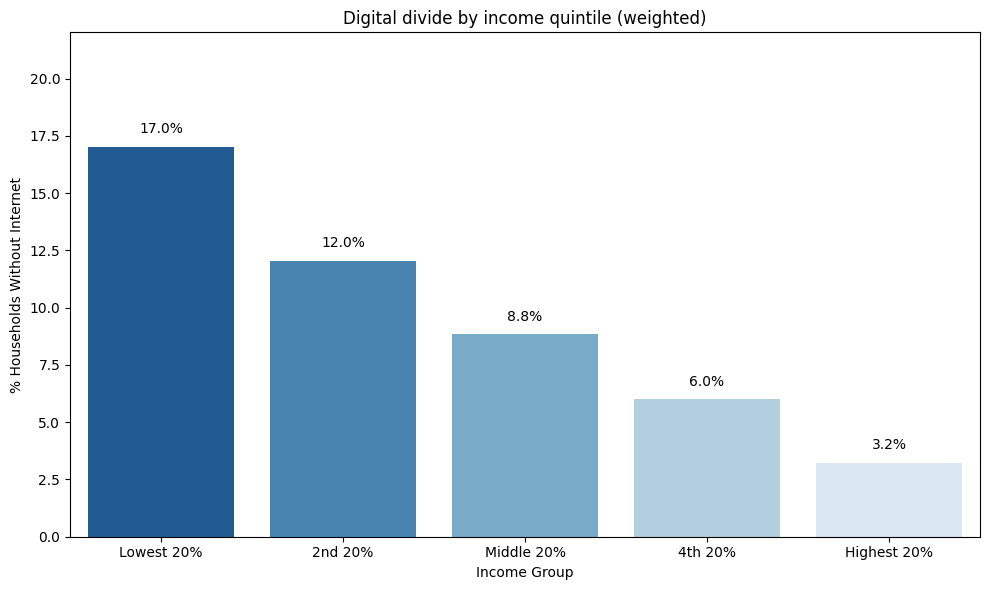

In [19]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats

needed = {"pct_no_internet","median_income","no_internet","hh_total_inet"}
missing = needed - set(df.columns)
assert not missing, f"Missing columns for this analysis: {missing}"

g = df[list(needed)].dropna().copy()
g = g[g["hh_total_inet"] > 0]

# Correlations
n = len(g)
pearson_r,  pearson_p  = stats.pearsonr(g["median_income"], g["pct_no_internet"])
spearman_r, spearman_p = stats.spearmanr(g["median_income"], g["pct_no_internet"])
print(f"Pearson r={pearson_r:.3f} (p={pearson_p:.1e}), Spearman ρ={spearman_r:.3f} (p={spearman_p:.1e}), n={n}")

# Income quintiles (weighted by households)
g = g.sort_values("median_income").copy()
g["income_group"] = pd.qcut(g["median_income"], 5,
                            labels=["Lowest 20%","2nd 20%","Middle 20%","4th 20%","Highest 20%"],
                            duplicates="drop")

def weighted_pct(d):
    return 100.0 * d["no_internet"].sum() / d["hh_total_inet"].sum()

income_table = (g.groupby("income_group", observed=True)
                  .apply(weighted_pct)
                  .rename("Pct_No_Internet").reset_index())

# Plot
plt.figure(figsize=(10,6))
ax = sns.barplot(x="income_group", y="Pct_No_Internet", data=income_table, palette="Blues_r")
ax.set_ylabel("% Households Without Internet"); ax.set_xlabel("Income Group")
ax.set_title("Digital divide by income quintile (weighted)")
ax.set_ylim(0, income_table["Pct_No_Internet"].max() + 5)
for i, v in enumerate(income_table["Pct_No_Internet"]): ax.text(i, v+0.6, f"{v:.1f}%", ha="center")
plt.tight_layout(); plt.show()




### 4. Modeling and Evaluation
---
*(Describe and present the analytic models built on the data and evaluate the performance of the models for solving the problem)*

,MAE,RMSE,R2
RandomForest,5.362,7.551,0.179
LassoCV,6.313,8.333,0.001
RidgeCV,6.313,8.333,0.001
Linear,6.313,8.333,0.001
MeanBaseline,6.314,8.336,0.000


RandomForest — Test MAE: 5.37 pp, RMSE: 7.59 pp, R²: 0.161


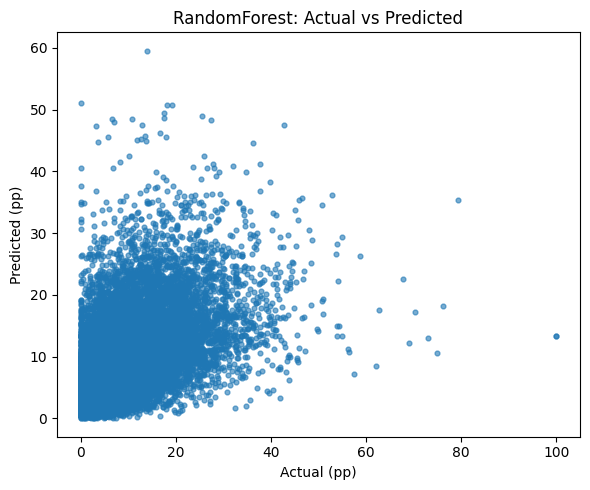

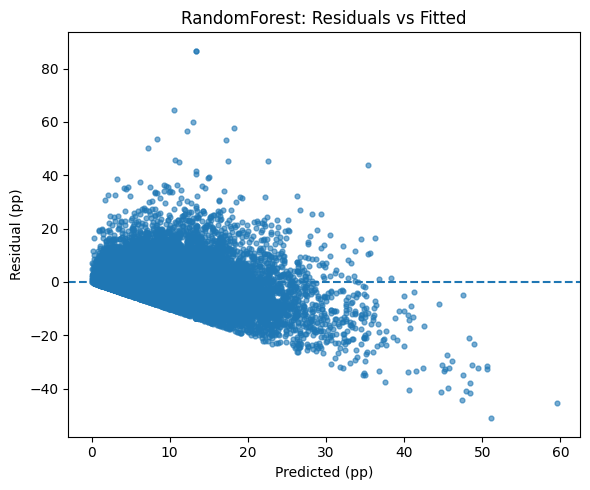

In [21]:
# --- 4. Modeling & Evaluation ---

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

SEED = 42

# ---------- helpers ----------
def rmse(y_true, y_pred):
    """Root-mean-squared error as float."""
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# scorer for cross_validate (negative because greater_is_better=False)
rmse_scorer = make_scorer(lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)),
                          greater_is_better=False)

# ---------- data for modeling ----------
dfm = df.copy()
dfm = dfm[(dfm["hh_total_inet"] > 0) & dfm["pct_no_internet"].notna()].copy()
dfm["target_pp"] = 100 * dfm["pct_no_internet"]      # target in percentage points

# choose features that actually exist in your df
num_feats = [c for c in [
    "median_income","log_median_income","bachelor_share","hs_grad_share",
    "median_gross_rent","persons_per_household","housing_median_age"
] if c in dfm.columns]

cat_feats = [c for c in ["state_name","income_q","edu_q","urban_rural","density_q"] if c in dfm.columns]

X = dfm[num_feats + cat_feats]
y = dfm["target_pp"]

# ---------- preprocessing ----------
pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer()), ("sc", StandardScaler())]), num_feats),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_feats),
], remainder="drop")

# ---------- models ----------
models = {
    "Linear": LinearRegression(),
    "RidgeCV": RidgeCV(alphas=np.logspace(-3, 3, 15)),
    "LassoCV": LassoCV(alphas=np.logspace(-3, 3, 15), random_state=SEED, max_iter=10000),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=SEED, n_jobs=-1),
}

scoring = {"MAE": "neg_mean_absolute_error", "RMSE": rmse_scorer, "R2": "r2"}
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

# ---------- cross-validated comparison ----------
rows = []
for name, est in models.items():
    pipe = Pipeline([("pre", pre), ("model", est)])
    cvres = cross_validate(pipe, X, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score=False)
    rows.append(pd.Series({
        "MAE":  -cvres["test_MAE"].mean(),
        "RMSE": -cvres["test_RMSE"].mean(),
        "R2":    cvres["test_R2"].mean()
    }, name=name))

tbl = pd.concat(rows, axis=1).T

# mean baseline (predict the overall mean of y)
baseline_pred = np.full_like(y, y.mean(), dtype=float)
tbl.loc["MeanBaseline"] = {
    "MAE": mean_absolute_error(y, baseline_pred),
    "RMSE": rmse(y, baseline_pred),
    "R2":  0.0,
}

tbl = tbl.sort_values("RMSE")
display(tbl.round(3))

# ---------- fit best model once; hold-out test & diagnostics ----------
best_name = tbl.index[0] if tbl.index[0] != "MeanBaseline" else tbl.index[1]
best_est  = models.get(best_name, LinearRegression())

pipe = Pipeline([("pre", pre), ("model", best_est)])
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=SEED)
pipe.fit(X_tr, y_tr)
pred = pipe.predict(X_te)

print(f"{best_name} — Test MAE: {mean_absolute_error(y_te, pred):.2f} pp, "
      f"RMSE: {rmse(y_te, pred):.2f} pp, R²: {r2_score(y_te, pred):.3f}")

# Actual vs Predicted
plt.figure(figsize=(6,5))
plt.scatter(y_te, pred, s=12, alpha=0.6)
plt.xlabel("Actual (pp)"); plt.ylabel("Predicted (pp)")
plt.title(f"{best_name}: Actual vs Predicted"); plt.tight_layout(); plt.show()

# Residuals
res = y_te - pred
plt.figure(figsize=(6,5))
plt.scatter(pred, res, s=12, alpha=0.6); plt.axhline(0, ls="--")
plt.xlabel("Predicted (pp)"); plt.ylabel("Residual (pp)")
plt.title(f"{best_name}: Residuals vs Fitted"); plt.tight_layout(); plt.show()

# ---------- optional: slice evaluation by income quintile if present ----------
if "income_q" in dfm.columns:
    te_idx = y_te.index
    slice_eval = (dfm.loc[te_idx]
                    .assign(y_true=y_te, y_pred=pred)
                    .groupby("income_q")
                    .apply(lambda d: pd.Series({
                        "MAE":  mean_absolute_error(d["y_true"], d["y_pred"]),
                        "RMSE": rmse(d["y_true"], d["y_pred"]),
                        "R2":   r2_score(d["y_true"], d["y_pred"])
                    })))
    display(slice_eval.round(3))


### 5. Conclusion
---
*(Briefly describe what you have done and what you discovered. Discuss any shortcomings of the process and results. Propose future work. **Finally, discuss the lessons learned from doing the project**.)*

### 6. References

---
# Use the following requirements for preparing your project:

## DO NOT DELETE THE CELLS BELLOW

# Project Requirements

This final project examines the level of knowledge the students have learned from the course. The following course outcomes will be checked against the content of the report:

Upon successful completion of this course, a student will be able to:
* observe and explore a variety of quantitative methods for data analysis;
* understand methods’ evaluation techniques to interpret their output;
* implement and evaluate methods to gain technical experience with data; and
* reproducibly execute an analytic project and represent/communicate its results faithfully.

** Marking will be foucsed on both presentation and content.**

## Written Presentation Requirements
The report will be judged on the basis of visual appearance, grammatical correctness, and quality of writing, as well as its contents. Please make sure that the text of your report is well-structured, using paragraphs, full sentences, and other features of well-written presentation.

## Technical Content:
* Is the problem well defined and described thoroughly?
* Is the size and complexity of the data set used in this project comparable to that of the example data sets used in the lectures and assignments?
* Did the report describe the charactriatics of the data?
* Did the report describe the goals of the data analysis?
* Did the analysis conduct exploratory analyses on the data?
* Did the analysis build analysis models of the data and evaluated the performance of the models?
* Overall, what is the rating of this project?